# Notebook 1 - Fuel property modeling

By Vincent Blay, June 2021

In this notebook we demonstrate the use of Macaw embeddings to describe molecules and train regression models of different molecular properties. The results illustrate the usefulness and speed of the approach and its compatibility with small and medium-sized datasets that are commonly found in the biosciences.

In [1]:
pwd

'C:\\Users\\Enka\\Desktop\\LDRD\\macaw_repo\\notebooks'

In [2]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVR
from sklearn_rvm import EMRVR

import macaw
print(macaw.__version__)

from macaw import *
%run "./plotting.py"

0.0.8


## Research Octane Number (RON)

Let us load the data and look at the distribution:

In [3]:
df = pd.read_csv("../data/data_RON.csv")
smiles = df.Smiles
Y = df.RON
print(len(smiles))

194


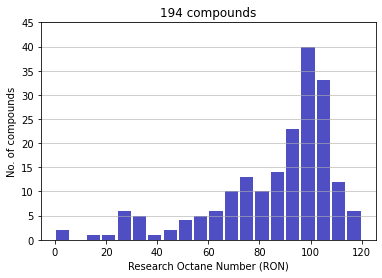

In [4]:
plot_histogram(Y, xlabel="Research Octane Number (RON)")

Let us split the data in training and validation sets:

In [5]:
smi_train, smi_test, y_train, y_test = train_test_split(smiles, Y, test_size=0.2, random_state=42)

Compute the Macaw embeddings of the molecules is very easy. We just initialize the embedder:

In [6]:
mcw = Macaw(smi_train)

And then we project the training molecules:

In [7]:
X_train = mcw.transform()
X_train[0:4]

array([[-0.32671155,  0.15055939,  0.00985048,  0.00370843,  0.13076039,
        -0.26217468,  0.15411429, -0.17791619,  0.12137473,  0.07120491,
        -0.0071165 ,  0.03260306,  0.1120317 ,  0.05456018, -0.03077879],
       [ 0.06804265, -0.11276574,  0.02919006, -0.13660723,  0.06051503,
        -0.12678952, -0.11488748,  0.2686904 , -0.02355363,  0.06054168,
        -0.04542996,  0.07027757,  0.08715376, -0.08146202, -0.127746  ],
       [-0.12006072,  0.183117  ,  0.02884313, -0.0306    ,  0.03671639,
        -0.10543065,  0.018178  , -0.06346408,  0.01715867, -0.049923  ,
         0.03661385, -0.01905699,  0.26912218, -0.12894872, -0.01345905],
       [ 0.16060258,  0.10657845, -0.10130612, -0.06145063,  0.02906163,
         0.0982768 , -0.07835855, -0.24453666,  0.12493016,  0.06836372,
         0.11791818, -0.10649913,  0.08037059,  0.00077057, -0.04563821]])

As an optional parameter, the property values can also be provided to the embedder (`Y=y_train`). In this case, it will choose the landmark molecules more uniformly throughout the RON range. If not provided (or if we had we set `Y=[]`) landmark molecules are chosen randomly.

Besides, a variety of fingerprints (`fptype`) and similarity metrics (`metric`) are available and can be tuned to maximize the performance in each problem.

In [8]:
mcw = Macaw(smi_train, fptype='atompairs', metric='rogot-goldberg', Nlndmk=100, edim =15, Y=y_train)
X_train = mcw.transform()
X_train[0:4]

array([[-0.32244594,  0.0553375 , -0.22278077,  0.27087612, -0.31145193,
         0.13169777, -0.09251394, -0.01037796, -0.0393889 ,  0.08451014,
        -0.01161247, -0.04159052,  0.14214301, -0.08477128,  0.09884096],
       [ 0.22479241,  0.13882276, -0.255121  , -0.18160979,  0.1351778 ,
        -0.199894  , -0.0095827 ,  0.14289319,  0.19977787,  0.099024  ,
        -0.17542245,  0.06707078,  0.04387936,  0.03313034,  0.05961733],
       [-0.28656362, -0.00391921, -0.02006639,  0.20574783, -0.00848072,
         0.01001807,  0.19050022, -0.15569404,  0.03021489,  0.03567796,
        -0.06392316, -0.02051735,  0.0773789 ,  0.00849977, -0.04162684],
       [-0.13548243,  0.17098914,  0.21819253,  0.02757394,  0.11843225,
         0.2838186 , -0.05225928,  0.02179188,  0.12033992,  0.02035101,
        -0.09584609, -0.03724775, -0.07341219, -0.06027315,  0.04307512]])

In order to automate the selection of the `fptype` and `metric`, we have implemented the function `Macaw_optimus`, which can help select a good combination. Internally, it trains a SVM, computes its cross-validation scores for different combinations of these hyperparameters, and returns the Macaw embedding for the best combination evaluated.

In [9]:
mcw = Macaw_optimus(smi_train, y_train, verbose=True, C=100, Y=y_train, edim=20, Nlndmk=100)

Problem type identified as regression
morgan2 + tanimoto: 0.566
morgan2 + cosine: 0.532
morgan2 + dice: 0.535
morgan2 + rogot-goldberg: 0.534
morgan3 + tanimoto: 0.563
morgan3 + cosine: 0.533
morgan3 + dice: 0.543
morgan3 + rogot-goldberg: 0.544
featmorgan3 + tanimoto: 0.506
featmorgan3 + cosine: 0.563
featmorgan3 + dice: 0.542
featmorgan3 + rogot-goldberg: 0.542
maccs + tanimoto: 0.676
maccs + cosine: 0.656
maccs + dice: 0.653
maccs + rogot-goldberg: 0.654
atompairs + tanimoto: 0.679
atompairs + cosine: 0.677
atompairs + dice: 0.674
atompairs + rogot-goldberg: 0.673
secfp + tanimoto: 0.460
secfp + cosine: 0.514
secfp + dice: 0.483
secfp + rogot-goldberg: 0.483
torsion + tanimoto: 0.534
torsion + cosine: 0.572
torsion + dice: 0.570
torsion + rogot-goldberg: 0.577
rdk7 + tanimoto: 0.559
rdk7 + cosine: 0.627
rdk7 + dice: 0.608
rdk7 + rogot-goldberg: 0.606
Setting recommended combination: atompairs + tanimoto


The embeddings for any new molecules can be commputed easily: we just provide the SMILES to the `transform()` method. Let us compute the embeddings of the test set molecules.

In [10]:
X_train = mcw.transform()
X_test = mcw.transform(smi_test)
X_test[0:4]

array([[ 0.05381086,  0.03416633,  0.21782075,  0.09719995,  0.00667969,
        -0.21497324,  0.03672749, -0.10522475, -0.01534523,  0.08039261,
        -0.13136685, -0.20625449, -0.02366299,  0.08478726,  0.05613933,
         0.03747975,  0.0964811 ,  0.01061046,  0.06257098, -0.00291678],
       [ 0.26242903, -0.0234248 ,  0.08832014, -0.21374988, -0.07342543,
        -0.06237542, -0.05207537, -0.16492338, -0.08942568, -0.02562276,
         0.01622279,  0.0930226 ,  0.16303161, -0.0924943 , -0.04128503,
        -0.08309046, -0.13951041, -0.03467706,  0.14892991, -0.05628635],
       [-0.04362713, -0.10645109,  0.04892153,  0.15285174, -0.00612945,
        -0.14992431,  0.13478231, -0.03949458,  0.13107459, -0.04204236,
        -0.05565322, -0.10716407, -0.0378531 , -0.03013024, -0.17284966,
        -0.00171363,  0.11709688,  0.01736503,  0.08915935,  0.05387395],
       [ 0.03908559, -0.27204711, -0.09438701,  0.01159003, -0.03706275,
         0.0016754 ,  0.19901085,  0.1065129 , -

In [11]:
X_test.shape

(39, 20)

Now we can use the embeddings as predictors for any machine learning tool, from linear models to neural networks. In this notebook, we will use Support Vector Machines (SVM).

As an example, here we explore a Support Vector Regressor (SVR) from the `sklearn` package.

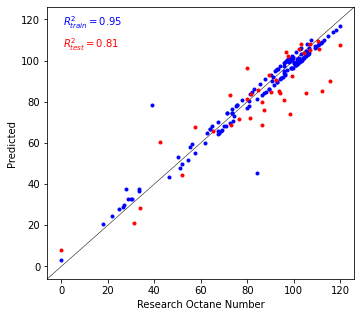

In [12]:
regr = SVR(kernel='rbf', C=100, epsilon=3)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred, 
            xlabel="Research Octane Number", savetitle="../data/RON.png") 

As another example, let us train a relevance vector regressor (RVR) using the same Macaw features. This type of model automatically deals with the regularization and provides uncertainty estimates of the predictions. Information about this package can be found [here](https://sklearn-rvm.readthedocs.io/en/latest/index.html).

In [13]:
regr = EMRVR(kernel='rbf', gamma='scale')
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred, y_train_std = regr.predict(X_train, return_std=True)

# Test set predictions
y_test_pred, y_test_std = regr.predict(X_test, return_std=True)

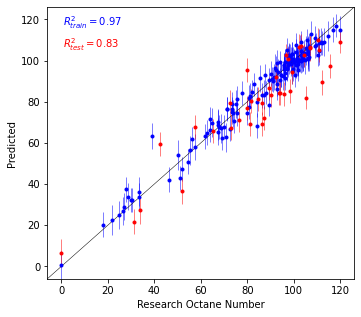

In [14]:
# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred, 
            y_train_std=y_train_std, y_test_std=y_test_std, xlabel="Research Octane Number") 

Let us save the Macaw embedder and the RON model for later use in Jupyter Notebook 3.

In [15]:
data = (mcw, regr)

picklefile = open("../data/RON_model_RVR.pickle", 'wb')
pickle.dump(data, picklefile, protocol=pickle.HIGHEST_PROTOCOL)
picklefile.close()

## Cetane Number (CN)

Here we demonstrate how Macaw embeddings can help model cetane numbers. We will use a similar approach as above. First we load the data:

In [16]:
df = pd.read_csv("../data/data_CN.csv")
smiles = df.Smiles
Y = df.CN
print(len(smiles))

545


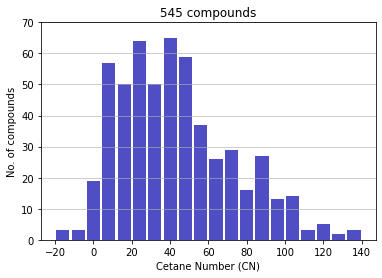

In [17]:
plot_histogram(Y, xlabel="Cetane Number (CN)")

In [18]:
smi_train, smi_test, y_train, y_test = train_test_split(smiles, Y, test_size=0.2, random_state=42)

In [19]:
y_train

46       3.0
93      -0.6
335    107.0
412     47.0
471     74.0
       ...  
71      81.3
106     10.0
270     26.0
435     40.0
102     22.0
Name: Cetane, Length: 436, dtype: float64

We compute the Macaw embeddings:

In [20]:
mcw = Macaw_optimus(smi_train, y_train, verbose=True, edim=15, Nlndmk=100)

X_train = mcw.transform()

Problem type identified as regression
morgan2 + tanimoto: 0.619
morgan2 + cosine: 0.621
morgan2 + dice: 0.621
morgan2 + rogot-goldberg: 0.621
morgan3 + tanimoto: 0.688
morgan3 + cosine: 0.685
morgan3 + dice: 0.684
morgan3 + rogot-goldberg: 0.683
featmorgan3 + tanimoto: 0.610
featmorgan3 + cosine: 0.621
featmorgan3 + dice: 0.607
featmorgan3 + rogot-goldberg: 0.607
maccs + tanimoto: 0.522
maccs + cosine: 0.532
maccs + dice: 0.527
maccs + rogot-goldberg: 0.530
atompairs + tanimoto: 0.731
atompairs + cosine: 0.692
atompairs + dice: 0.705
atompairs + rogot-goldberg: 0.710
secfp + tanimoto: 0.598
secfp + cosine: 0.590
secfp + dice: 0.585
secfp + rogot-goldberg: 0.585
torsion + tanimoto: 0.660
torsion + cosine: 0.655
torsion + dice: 0.655
torsion + rogot-goldberg: 0.656
rdk7 + tanimoto: 0.565
rdk7 + cosine: 0.573
rdk7 + dice: 0.545
rdk7 + rogot-goldberg: 0.546
Setting recommended combination: atompairs + tanimoto


Let us train a SVR model. We try different values of the regularization constant `C` to improve its performance:

In [21]:
X_train = mcw.transform()

for C in [30,50,100,300]:
    regr = SVR(kernel='rbf', C=C, epsilon=5)
    scores = cross_val_score(regr, X_train, y_train, cv=5)
    print(scores.mean())

0.7888549105564032
0.8034366761764566
0.8162636296934209
0.8113884615032767


We train the final model with the best value `C=100` and validate the model performance on the test set:

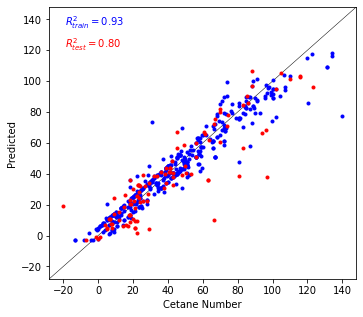

In [22]:
regr = SVR(kernel='rbf', C=100, epsilon=5)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
X_test = mcw.transform(smi_test)
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, xlabel="Cetane Number", 
            y_test=y_test_pred, savetitle="../data/CN.png") 

## Yield Sooting Index

Here we demonstrate how Macaw embeddings can help model Yield Soot Index (YSI), another complex molecular property.

In [23]:
df = pd.read_csv('../data/data_YSI4.csv')
smiles = df.Smiles
Y = df.YSI
print(len(smiles))

610


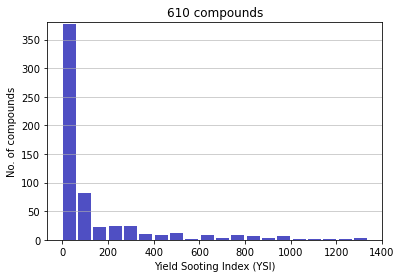

In [24]:
plot_histogram(Y, xlabel="Yield Sooting Index (YSI)")

In this case, we see that the data distribution is very skewed. There are different approaches to deal with this, for example, we could transform the YSI values to  get a more uniform distribution. For illustration purposes, we will work with the data as is.

We apply a stratified sampling to hold out the validation set in this case:

In [25]:
bins = np.linspace(min(Y), max(Y), 10+1)
Y_binned = np.digitize(Y, bins[:-1])
smi_train, smi_test, y_train, y_test = train_test_split(smiles, Y, test_size=0.2, random_state=42, stratify=Y_binned)

Next we compute the Macaw embeddings using only training data. In a case like this, it is recommended to provide property information (`Y=y_train`) to achieve a more balanced choice of landmarks. 

In [26]:
mcw = Macaw_optimus(smi_train, y_train)

X_train = mcw.transform()

Problem type identified as regression
Setting recommended combination: atompairs + dice


Since we did not transform the YSI data, we may want to introduce sample weights in the model. The way we do it here is by binning molecules as a function of YSI values, and then 
setting the weight of each datum in inverse proportion to the number of molecules in the bucket.

In [27]:
nbins = 10
leny = len(y_train)
bins = np.linspace(min(y_train), max(y_train), nbins+1)
y_binned = np.digitize(y_train, bins[:-1])
weights = [1./nbins]*leny
for i in range(leny):
    weights[i] = weights[i]/sum(y_binned==y_binned[i])
weights = np.asarray(weights)
weights = weights/weights.mean()

Now we can train the model. As in the other regression examples, we use a SVR. For this model, the weights provided will scale the regularization in different regions of space, in relation to the global regularization set by `C`.

In [28]:
for C in [30,100,300,500]:
    regr = SVR(kernel='rbf', C=C, epsilon=20)
 
    scores = cross_val_score(regr, X_train, y_train, cv=5, fit_params={'sample_weight': weights})
    print(scores.mean())

0.46464008261261974
0.7078408273755901
0.7867874418473956
0.8004249699419758


And we train the final model:

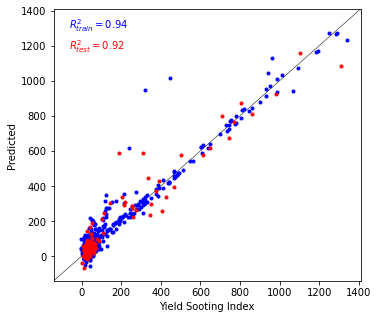

In [29]:
regr = SVR(kernel = 'rbf', C=500, epsilon=20)
regr.fit(X_train,y_train, sample_weight=weights)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
X_test = mcw.transform(smi_test)
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train,y=y_train_pred,x_test=y_test,y_test=y_test_pred, xlabel="Yield Sooting Index") 

##  Melting Point (MP)

In [30]:
df = pd.read_csv("../data/data_MP.csv")
smiles = df.Smiles
Y = df.mpC
print(len(smiles))

27976


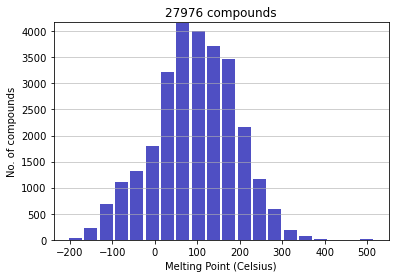

In [31]:
plot_histogram(Y, xlabel="Melting Point (Celsius)")

In [32]:
%%capture  
#hide the output of this cell
smiles, indx = smiles_clean(smiles, idx=True)
Y = Y[indx]

In [33]:
smi_train, smi_test, y_train, y_test = train_test_split(smiles, Y, test_size=0.2, random_state=42)
print(len(smi_train))

22380


In [34]:
mcw = Macaw_optimus(smi_train, y_train, C=50)

Problem type identified as regression
Setting recommended combination: maccs + rogot-goldberg


In [35]:
X_train = mcw.transform()

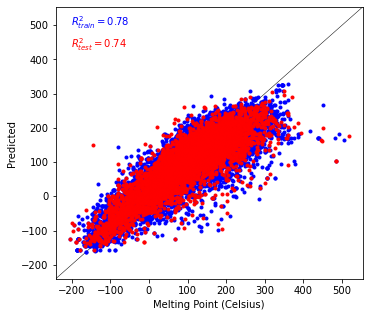

In [36]:
regr = SVR(kernel = 'rbf', C=100, epsilon = 20)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
X_test = mcw.transform(smi_test)
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred,
            xlabel="Melting Point (Celsius)", savetitle="../data/MP.png") 

Macaw also allows to concatenate fingerprints, which may improve performance in some cases:

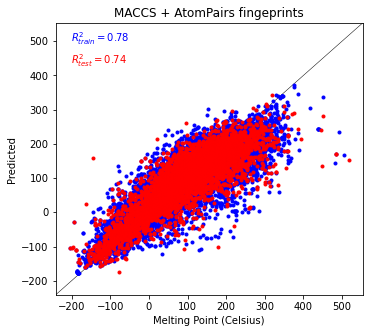

In [37]:
mcw.set_fptype('maccs+atompairs')
mcw.set_metric('cosine')

X_train = mcw.transform()

regr = SVR(kernel='rbf', C=100, epsilon=5)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
X_test = mcw.transform(smi_test)
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred, 
            xlabel="Melting Point (Celsius)", title="MACCS + AtomPairs fingeprints") 

## Flash Point (FP)

In [38]:
df = pd.read_csv("../data/data_FP.csv")
smiles = df.Smiles
Y = df.FP
print(len(smiles))

631


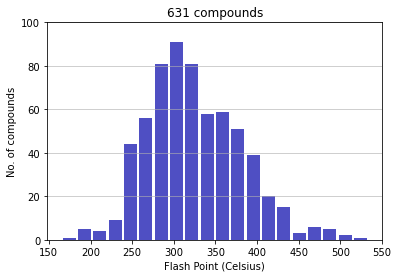

In [39]:
plot_histogram(Y, xlabel="Flash Point (Celsius)")

In [40]:
smiles, indx = smiles_clean(smiles, idx=True)
Y = Y[indx]

In [41]:
smi_train, smi_test, y_train, y_test = train_test_split(smiles, Y, test_size=0.2, random_state=42)
print(len(smi_train))

504


In [42]:
mcw = Macaw_optimus(smi_train, y_train, C=300)

X_train = mcw.transform()

Problem type identified as regression
Setting recommended combination: atompairs + rogot-goldberg


In [43]:
for C in [50,100,200,300,500]:
    regr = SVR(kernel='rbf', C=C, epsilon=2)

    scores = cross_val_score(regr, X_train, y_train, cv=5)
    print(scores.mean())

0.7965287034535987
0.827472045243875
0.8389981629062186
0.842898222506945
0.8419103446454755


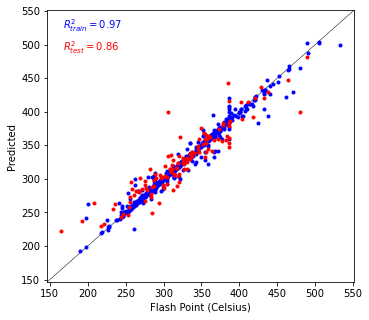

In [44]:
regr = SVR(kernel='rbf', C=300, epsilon=2)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
X_test = mcw.transform(smi_test)
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred,
            xlabel="Flash Point (Celsius)", savetitle="../data/FP.png") 